In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Load the data
file_path = "/kaggle/input/wwwwwwwwwwww/Model_1.txt"
df = pd.read_csv(file_path, sep='\\s+')  # Replace delim_whitespace with sep='\\s+'

# Prepare data for training
X = df[['Depth[km]']].values  # Input features (depth)
y_vp = df['Vp[km/s]'].values  # Target for P-wave velocity
y_vs = df['Vs[km/s]'].values  # Target for S-wave velocity
rho = df['Rho[g/cm3]'].values  # Density for physics-informed loss

# Normalize the data
X_mean, X_std = X.mean(), X.std()
X = (X - X_mean) / X_std
y_vp_mean, y_vp_std = y_vp.mean(), y_vp.std()
y_vp = (y_vp - y_vp_mean) / y_vp_std
y_vs_mean, y_vs_std = y_vs.mean(), y_vs.std()
y_vs = (y_vs - y_vs_mean) / y_vs_std

# Define the PINN model
def build_pinn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),  # Use Input(shape=...)
        layers.Dense(64, activation='tanh'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)  # Single output
    ])
    return model

# Create separate models for Vp and Vs
model_vp = build_pinn(X.shape[1])
model_vs = build_pinn(X.shape[1])

# Define physics-informed loss for Vp
@tf.function
def physics_loss_vp(y_true, y_pred):
    # Compute predicted Lamé parameter (bulk modulus + 2*shear modulus)
    lam = tf.square(y_pred) * rho  # Approximation based on Vp
    # Physics constraint: Lamé parameter should remain non-negative
    penalty = tf.reduce_mean(tf.nn.relu(-lam))
    return tf.reduce_mean(tf.square(y_true - y_pred)) + penalty

# Define physics-informed loss for Vs
@tf.function
def physics_loss_vs(y_true, y_pred):
    # Compute predicted shear modulus (mu)
    mu = tf.square(y_pred) * rho
    # Physics constraint: Shear modulus should remain non-negative
    penalty = tf.reduce_mean(tf.nn.relu(-mu))
    return tf.reduce_mean(tf.square(y_true - y_pred)) + penalty

# Compile the models with physics-informed loss
model_vp.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=physics_loss_vp)
model_vs.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=physics_loss_vs)

# Train the models
history_vp = model_vp.fit(X, y_vp, epochs=500, batch_size=32, verbose=1)
history_vs = model_vs.fit(X, y_vs, epochs=500, batch_size=32, verbose=1)

# Make predictions
predicted_vp = model_vp.predict(X)
predicted_vs = model_vs.predict(X)

# Post-process predictions
predicted_vp = predicted_vp * y_vp_std + y_vp_mean
predicted_vs = predicted_vs * y_vs_std + y_vs_mean

# Add predictions to DataFrame
df['Predicted_Vp'] = predicted_vp.flatten()
df['Predicted_Vs'] = predicted_vs.flatten()

# Save results to a file
df.to_csv('predicted_wave_speeds.csv', index=False)


Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0424
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8366 
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8468 
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0279 
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7660 
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9995 
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8875 
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8353 
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8037 
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9864 
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8305 
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9164 
Epoch 13/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8657 
Epoch 14/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9947 
Epoch 15/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8203 
Epoch 16/500
5/5 ━━━

# Well trained PINN


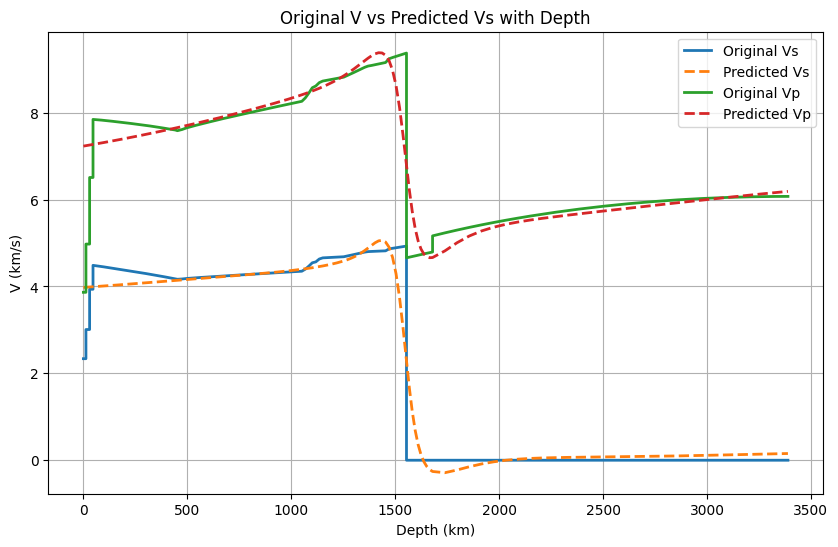

In [28]:
import matplotlib.pyplot as plt

# Plot original Vs and predicted Vs against Depth
plt.figure(figsize=(10, 6))
plt.plot(df['Depth[km]'], df['Vs[km/s]'], label='Original Vs', linewidth=2)
plt.plot(df['Depth[km]'], df['Predicted_Vs'], label='Predicted Vs', linestyle='--', linewidth=2)
plt.plot(df['Depth[km]'], df['Vp[km/s]'], label='Original Vp', linewidth=2)
plt.plot(df['Depth[km]'], df['Predicted_Vp'], label='Predicted Vp', linestyle='--', linewidth=2)
# Add labels, title, and legend
plt.xlabel('Depth (km)')
plt.ylabel('V (km/s)')
plt.title('Original V vs Predicted Vs with Depth')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Now we will do with normal gradient boost

Training MSE (Vp): 0.0870
Testing MSE (Vp): 0.0932
Training MSE (Vs): 0.0461
Testing MSE (Vs): 0.0484


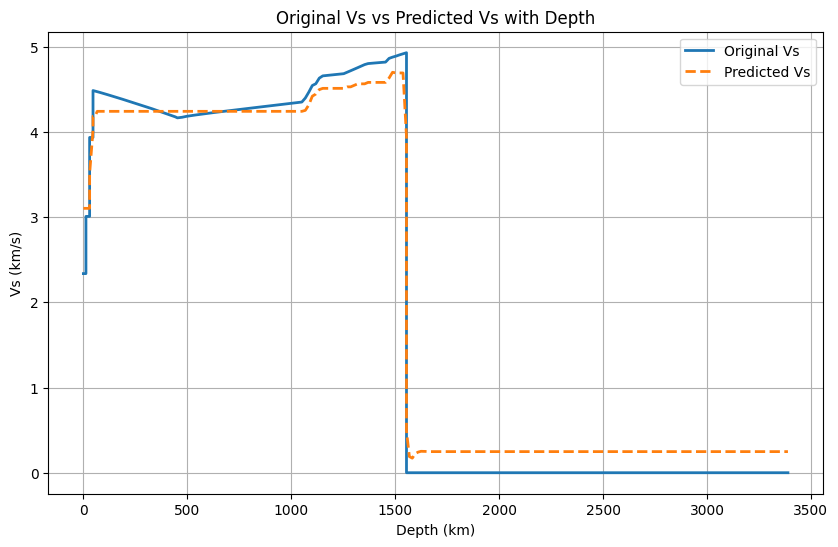

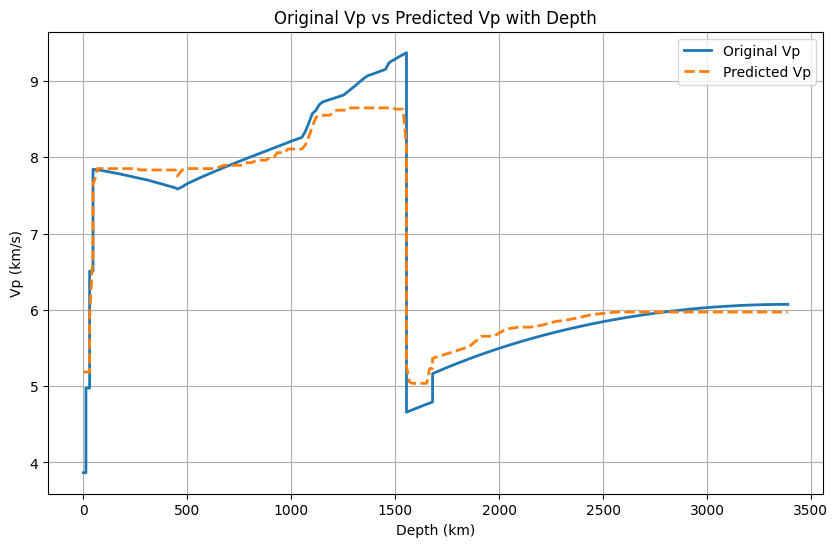

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
file_path = "/kaggle/input/wwwwwwwwwwww/Model_1.txt"  # Update with your file path
df = pd.read_csv(file_path, sep='\\s+')

# Prepare features and target variables
X = df[['Depth[km]', 'Rho[g/cm3]']]  # Features
y_vp = df['Vp[km/s]']  # Target for P-wave velocity
y_vs = df['Vs[km/s]']  # Target for S-wave velocity

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_vp_train, y_vp_test, y_vs_train, y_vs_test = train_test_split(
    X, y_vp, y_vs, test_size=0.3, train_size=0.7, random_state=42
)

# Optimized Gradient Boosting Regressor (to reduce overfitting)
gb_model_vp = GradientBoostingRegressor(
    n_estimators=50, learning_rate=0.05, max_depth=2, 
    min_samples_split=5, min_samples_leaf=3, subsample=0.8, random_state=42
)

gb_model_vs = GradientBoostingRegressor(
    n_estimators=50, learning_rate=0.05, max_depth=2, 
    min_samples_split=5, min_samples_leaf=3, subsample=0.8, random_state=42
)

# Train the models
gb_model_vp.fit(X_train, y_vp_train)
gb_model_vs.fit(X_train, y_vs_train)

# Make predictions
df['Predicted_Vp'] = gb_model_vp.predict(X)
df['Predicted_Vs'] = gb_model_vs.predict(X)

# Evaluate the model
train_mse_vp = mean_squared_error(y_vp_train, gb_model_vp.predict(X_train))
test_mse_vp = mean_squared_error(y_vp_test, gb_model_vp.predict(X_test))
train_mse_vs = mean_squared_error(y_vs_train, gb_model_vs.predict(X_train))
test_mse_vs = mean_squared_error(y_vs_test, gb_model_vs.predict(X_test))

print(f'Training MSE (Vp): {train_mse_vp:.4f}')
print(f'Testing MSE (Vp): {test_mse_vp:.4f}')
print(f'Training MSE (Vs): {train_mse_vs:.4f}')
print(f'Testing MSE (Vs): {test_mse_vs:.4f}')

# Plot original Vs and predicted Vs against Depth
plt.figure(figsize=(10, 6))
plt.plot(df['Depth[km]'], df['Vs[km/s]'], label='Original Vs', linewidth=2)
plt.plot(df['Depth[km]'], df['Predicted_Vs'], label='Predicted Vs', linestyle='--', linewidth=2)

depth

plt.xlabel('Depth (km)')
plt.ylabel('Vs (km/s)')
plt.title('Original Vs vs Predicted Vs with Depth')
plt.legend()
plt.grid(True)
plt.show()

# Plot original Vp and predicted Vp against Depth
plt.figure(figsize=(10, 6))
plt.plot(df['Depth[km]'], df['Vp[km/s]'], label='Original Vp', linewidth=2)
plt.plot(df['Depth[km]'], df['Predicted_Vp'], label='Predicted Vp', linestyle='--', linewidth=2)

plt.xlabel('Depth (km)')
plt.ylabel('Vp (km/s)')
plt.title('Original Vp vs Predicted Vp with Depth')
plt.legend()
plt.grid(True)
plt.show()


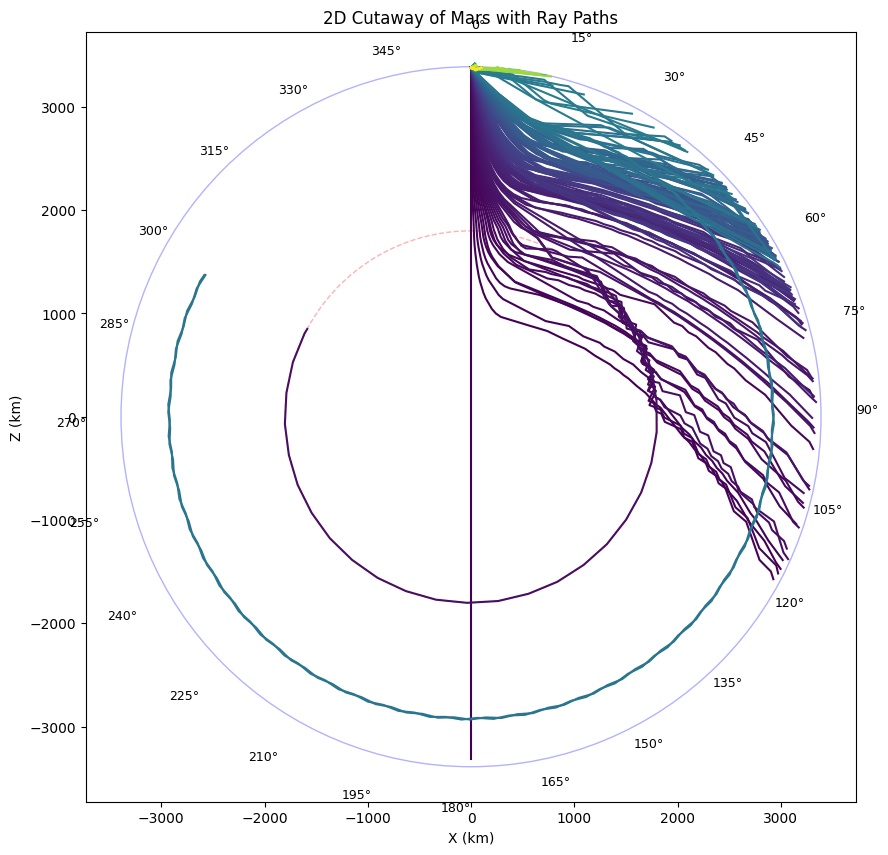

117.71818556886532


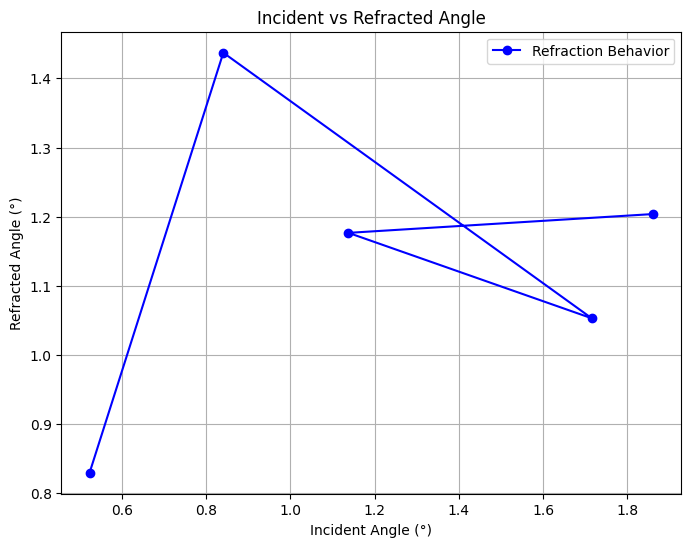

In [35]:
import pandas as pd
import os
# Import necessary modules for further processing
import numpy as np
import matplotlib.pyplot as plt


# Define constants and Mars' structure
R_MARS = 3389.5  # Radius of Mars in km
R_CORE = 1550.0  # Radius of the Mars' core in km
STEP_SIZE = 10.0

# Load seismic data

def get_slowness_2d(position, velfield):
    """Determine P-wave slowness based on depth in 2D."""
    global marsdf
    dep = abs(R_MARS - np.linalg.norm(position))
    lower_row = marsdf[marsdf["Depth[km]"] <= dep].iloc[-1]
    v = lower_row[velfield]
    return 1.0 / v if v > 0 else 0

def snells_angle(vector):
    y, x = vector[1], vector[0]
    a = np.arctan2(y, x)
    if abs(a) <= np.pi / 2:
        return np.pi / 2 + a
    else:
        return (a - np.pi * 3 / 2) if a > 0 else (a + np.pi / 2)

out_subtends = None

anglepairs = []

def trace_ray_2d(origin, direction, velfield, max_steps=1000):
    """
    Trace the path of a seismic ray in 2D.
    Parameters:
    origin (tuple): The starting point of the ray as a tuple of (x, y) coordinates.
    direction (tuple): The initial direction of the ray as a tuple of (x, y) components.
    max_steps (int, optional): The maximum number of steps to trace the ray. Default is 1000.
    Returns:
    list: A list of tuples representing the path of the ray.
    The function simulates the propagation of a seismic ray through a 2D medium. 
    It iteratively updates the ray's position based on the local slowness and handles 
    refraction at boundaries where the slowness changes. The ray tracing stops if the 
    slowness becomes zero, the ray exits the medium (e.g., outside Mars), or the maximum 
    number of steps is reached.
    The function also checks if the ray reaches a specific radius (3300 units) and 
    sets a flag. If the ray moves beyond this radius after setting the flag, it calculates 
    the subtended angle and terminates the tracing if the angle difference is within 15 degrees.
    Note:
    - The function assumes the existence of external functions `get_slowness_2d` and 
      `snells_angle` which are used to get the slowness at a position and calculate 
      Snell's law refraction angles, respectively.
    - `STEP_SIZE` and `R_MARS` are assumed to be predefined constants.
    - `out_subtends` is assumed to be a global variable used to store the subtended angle.
    """
    """Trace the path of a seismic ray in 2D."""
    path = [origin]
    current_position = np.array(origin)
    current_radius = np.linalg.norm(current_position)
    current_direction = np.array(direction)
    flag = False

    for _ in range(max_steps):
        # Get the current slowness at the current position
        current_slowness = get_slowness_2d(current_position, velfield)
        if current_slowness == 0:
            print("Ray terminated: current_slowness == 0")
            break

        # Calculate the step distance based on the slowness
        step_distance = STEP_SIZE * (1 / (current_slowness ))
        tentative_position = current_position + step_distance * current_direction
        new_slowness = get_slowness_2d(tentative_position, velfield)

        # Break if the new slowness is zero or the position is outside Mars
        if new_slowness == 0:
            break
        if np.linalg.norm(tentative_position) > R_MARS:
            break
        global anglepairs
        # Handle refraction if the slowness changes
        if new_slowness != current_slowness:
            normal = current_position / np.linalg.norm(current_position)

            norm_angle = snells_angle(-normal)
            dir_angle = snells_angle(current_direction)
            incidence_angle = dir_angle - norm_angle
            sin_refract = (current_slowness / new_slowness) * np.sin(incidence_angle)

            # Check for valid refraction
            if -1 <= sin_refract <= 1:
                refraction_angle = np.arcsin(sin_refract) 
                # 2D rotation matrix for refraction
                
                z = (-np.cos(refraction_angle))
                y = (np.sin(refraction_angle))
                current_direction = np.array([y, z])

                current_direction /= np.linalg.norm(current_direction)
                anglepairs.append((incidence_angle, refraction_angle))

            else:
                current_direction = current_direction - 2 * np.dot(current_direction, normal) * normal


        # Update the current position and add it to the path
        current_radius = np.linalg.norm(current_position)
        current_position += step_distance * current_direction
        
        if current_radius <= 3300:
            flag = True
        global out_subtends
        
        if current_radius > 3300 and flag:
            a = 180 - np.rad2deg(snells_angle(vector=current_position))
            if out_subtends == 0:
                out_subtends = a
                if abs(a - out_subtends) <= 15:
                    a = max(a, out_subtends)  
            return path
        
        path.append(tuple(current_position))

    return path

def plot_mars_cutaway_with_rays_2d(raypaths, mars_radius=3389.5, core_mantle_boundary=1800.0):
    """Plots a 2D cutaway of Mars with ray paths and angle labels."""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Circle for Mars' surface
    mars_circle = plt.Circle((0, 0), mars_radius, color='blue', alpha=0.3, fill=False)
    ax.add_patch(mars_circle)

    # Circle for Mars' core
    core_circle = plt.Circle((0, 0), core_mantle_boundary, color='red', alpha=0.3, linestyle='dashed', fill=False)
    ax.add_patch(core_circle)

    # Plot ray paths in distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(raypaths)))
    for raypath, color in zip(raypaths, colors):
        x_coords = [point[0] for point in raypath]
        z_coords = [point[1] for point in raypath] # z-coords are the second element in 2D tuples
        ax.plot(x_coords, z_coords, color=color, linewidth=1.5)

    # Add angle labels
    angles = np.arange(0, 360, 15)
    label_radius = mars_radius * 1.1  # Radius for label positions

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        x_label = label_radius * np.sin(angle_rad)
        z_label = label_radius * np.cos(angle_rad)

        # Adjust text alignment based on angle to be outside the circle
        ha = 'center'
        va = 'center'
        if 0 <= angle < 90:
            ha = 'left'
            va = 'bottom'
        elif 90 <= angle < 180:
            ha = 'right'
            va = 'bottom'
        elif 180 <= angle < 270:
            ha = 'right'
            va = 'top'
        elif 270 <= angle < 360:
            ha = 'left'
            va = 'top'
        if angle == 0:
            va = 'bottom'
        if angle == 90:
            ha = 'left'
        if angle == 180:
            va = 'top'
        if angle == 270:
            ha = 'right'

        ax.text(x_label, z_label, f'{angle}°', ha=ha, va=va, fontsize=9)


    # Formatting the plot
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    ax.set_title("2D Cutaway of Mars with Ray Paths")
    ax.set_aspect('equal') # Ensure circles look like circles
    ax.set_xlim(-mars_radius*1.1, mars_radius*1.1)
    ax.set_ylim(-mars_radius*1.1, mars_radius*1.1)
    plt.show()


# Generate ray paths in 2

# Find the min and max angles for each cluster
depthmodels = [df]
for m in depthmodels:
    
    marsdf = m
    out_subtends = 0

    origin_2d = (0, R_MARS - 10.0)
    raypaths_2d = []
    angles = [0.2 * k for k in range(0, 360)]
    
    for ang in angles:
        direction_2d = (
            np.sin(np.radians(ang)),
            -np.cos(np.radians(ang))
        )
        direction_2d = direction_2d / np.linalg.norm(direction_2d)
        raypath = trace_ray_2d(origin_2d, velfield = 'Predicted_Vp', direction=direction_2d, max_steps=200)
       
        raypaths_2d.append(raypath)

    plot_mars_cutaway_with_rays_2d(raypaths_2d)

    print(out_subtends)

anglepairs = []
direction_2d = (
            np.sin(np.radians(30)),
            -np.cos(np.radians(30))
        )
direction_2d = direction_2d / np.linalg.norm(direction_2d)
raypath = trace_ray_2d(origin_2d, velfield = 'Predicted_Vp', direction=direction_2d, max_steps=200)

#for a single wave, refraction angles graph:
incident_angles, refracted_angles = zip(*anglepairs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(incident_angles, refracted_angles, marker='o', linestyle='-', color='b', label="Refraction Behavior")

# Labels and title
plt.xlabel("Incident Angle (°)")
plt.ylabel("Refracted Angle (°)")
plt.title("Incident vs Refracted Angle")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0, Loss: 0.081933
Epoch 10, Loss: 0.003522
Epoch 20, Loss: 0.005871
Epoch 30, Loss: 0.001197
Epoch 40, Loss: 0.001372
Epoch 50, Loss: 0.000694
Epoch 60, Loss: 0.000576
Epoch 70, Loss: 0.000385
Epoch 80, Loss: 0.000287
Epoch 90, Loss: 0.000206


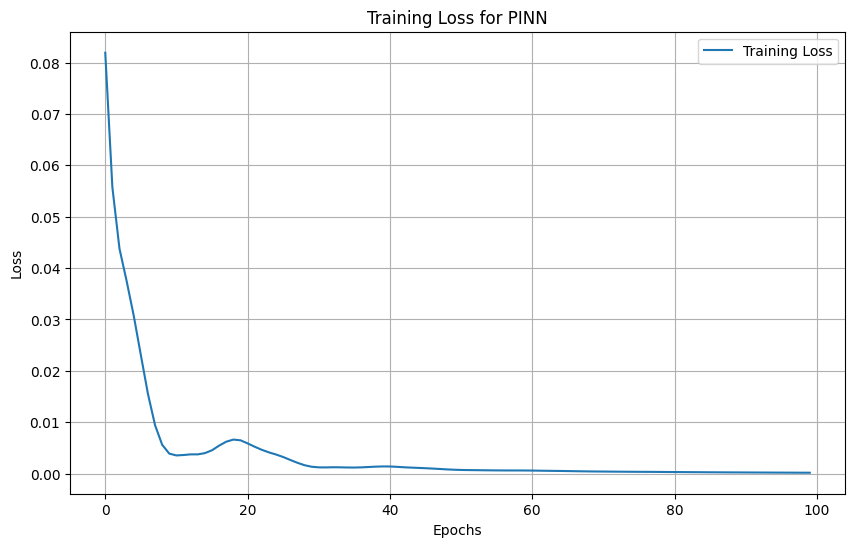

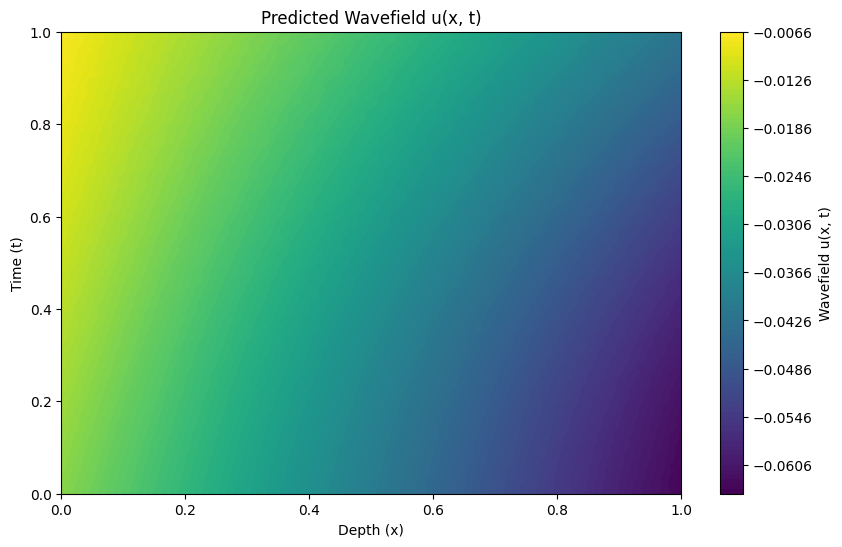

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Enable mixed precision for faster training
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
except AttributeError:
    pass  # Mixed precision not available on some setups

# Step 1: Load the dataset
file_path = '/kaggle/input/wwwwwwwwwwww/Model_1.txt'  # Update the file path as needed
df = pd.read_csv(file_path, sep='\s+')

# Extract depth, Vp, and Vs from the dataset
x_train = df['Depth[km]'].values[:, None]  # Depth
vp_train = df['Vp[km/s]'].values[:, None]  # P-wave velocity
vs_train = df['Vs[km/s]'].values[:, None]  # S-wave velocity
rho_train = df['Rho[g/cm3]'].values[:, None]  # Density

# Normalize the data for training
x_mean, x_std = x_train.mean(), x_train.std()
x_train_normalized = (x_train - x_mean) / x_std

vp_mean, vp_std = vp_train.mean(), vp_train.std()
vp_train_normalized = (vp_train - vp_mean) / vp_std

vs_mean, vs_std = vs_train.mean(), vs_train.std()
vs_train_normalized = (vs_train - vs_mean) / vs_std

# Step 2: Define the PINN model for Wavefield
def build_pinn():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),  # Inputs: Depth and Time
        tf.keras.layers.Dense(32, activation='tanh'),  # Reduced neurons for efficiency
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)  # Output: Wavefield u(x, t)
    ])
    return model

# Instantiate the PINN
pinn_model = build_pinn()

# Step 3: Define wave speed as a function of depth
@tf.function
def wave_speed(x):
    return tf.constant(2.0, dtype=tf.float32) + x  # Example linear wave speed variation

# Step 4: Define the PINN loss function
@tf.function
def pinn_loss(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        inputs = tf.concat([x, t], axis=1)
        u = pinn_model(inputs)

        # Compute derivatives
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)
        u_tt = tape.gradient(u_t, t)

    # Compute wave speed
    c = wave_speed(x)

    # PDE residual: u_tt = c^2 * u_xx
    pde_residual = u_tt - (c ** 2) * u_xx
    pde_loss = tf.reduce_mean(tf.square(pde_residual))

    return pde_loss

# Step 5: Define training data points (reduced collocation points)
n_samples = 200  # Reduced number of samples
x_train = np.linspace(0, 1, n_samples)[:, None]  # Depth (normalized)
t_train = np.linspace(0, 1, n_samples)[:, None]  # Time (normalized)
x_train, t_train = np.meshgrid(x_train, t_train)
x_train_flat = x_train.flatten()[:, None]
t_train_flat = t_train.flatten()[:, None]

# Step 6: Training the PINN (reduced epochs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
n_epochs = 100  # Reduced number of epochs
loss_history = []

for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        loss = pinn_loss(tf.constant(x_train_flat, dtype=tf.float32),
                         tf.constant(t_train_flat, dtype=tf.float32))
    gradients = tape.gradient(loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))

    loss_history.append(loss.numpy())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

# Step 7: Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for PINN')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Predict wavefield and visualize
x_test = np.linspace(0, 1, 100)[:, None]
t_test = np.linspace(0, 1, 100)[:, None]
x_test, t_test = np.meshgrid(x_test, t_test)
x_test_flat = x_test.flatten()[:, None]
t_test_flat = t_test.flatten()[:, None]
inputs_test = np.hstack([x_test_flat, t_test_flat])
u_pred = pinn_model(tf.constant(inputs_test, dtype=tf.float32)).numpy().reshape(100, 100)

plt.figure(figsize=(10, 6))
plt.contourf(x_test, t_test, u_pred, levels=100, cmap='viridis')
plt.colorbar(label='Wavefield u(x, t)')
plt.xlabel('Depth (x)')
plt.ylabel('Time (t)')
plt.title('Predicted Wavefield u(x, t)')
plt.show()


Validation MSE: 0.255608


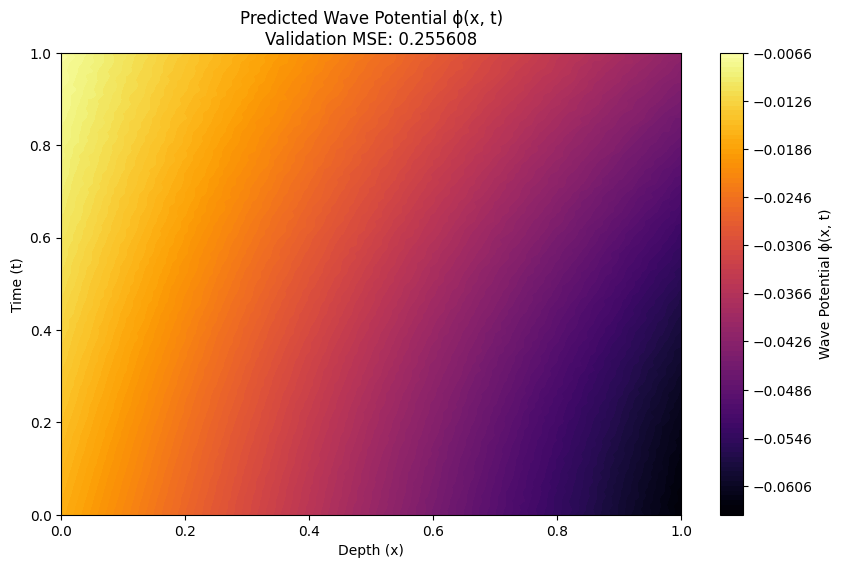

In [37]:
phi_pred = pinn_model(tf.constant(inputs_test, dtype=tf.float32)).numpy().reshape(100, 100)

# Compute validation loss (MSE)
phi_true = np.sin(np.pi * x_test) * np.cos(np.pi * t_test)  # Example expected solution
validation_mse = mean_squared_error(phi_true.flatten(), phi_pred.flatten())
print(f"Validation MSE: {validation_mse:.6f}")

# Plot predicted wave potential
plt.figure(figsize=(10, 6))
plt.contourf(x_test, t_test, phi_pred, levels=100, cmap='inferno')
plt.colorbar(label='Wave Potential ϕ(x, t)')
plt.xlabel('Depth (x)')
plt.ylabel('Time (t)')
plt.title(f'Predicted Wave Potential ϕ(x, t)\nValidation MSE: {validation_mse:.6f}')
plt.show()
